In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU

import pydicom

In [2]:
tf.__version__

'2.0.0'

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
EPOCHS = 6
lr = 3e-2
CHANNELS =1
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

FILTER_SIZE = 3

In [4]:
val_data_dir = '/opt/AIStorage/PLAYGROUND/data/validation'
val_data_dir = pathlib.Path(val_data_dir)

data_dir = '/opt/AIStorage/PLAYGROUND/data/train'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

3196

In [6]:
val_image_count = len(list(val_data_dir.glob('*/*.png')))
val_image_count

798

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

In [8]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [9]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = tf.constant([1.0, 0.0])
  else:
    label = tf.constant([0.0, 1.0])
  return label

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
  img = rotate(img)
  img = flip(img)
  return img

In [12]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [15]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 1)
Label:  [0. 1.]


In [16]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (512, 512, 1)
Label:  [0. 1.]


In [17]:
def prepare_for_training(ds, shuffle=True, cache=False, shuffle_buffer_size=4000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [18]:
train_ds = prepare_for_training(labeled_ds)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds


In [19]:
train_ds

<DatasetV1Adapter shapes: ((None, 512, 512, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [20]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(np.squeeze(image_batch[n]), cmap='gray')
      
      plt.axis('off')

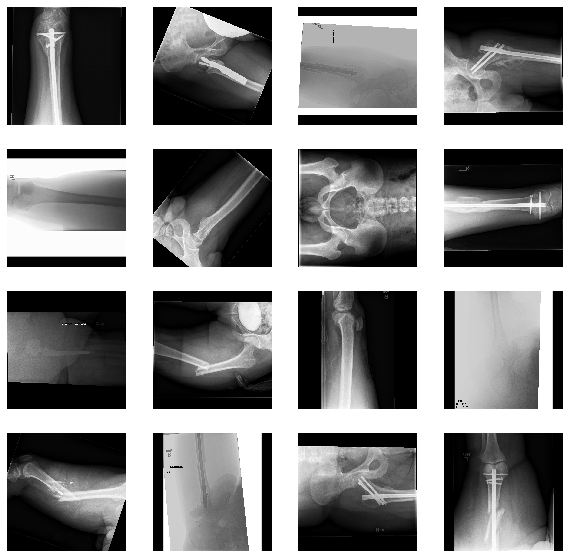

In [21]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

In [22]:
class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
 

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            print('get lr error')
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            print('get momentum error')
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            print('set lr error')
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            print('set momentum error')
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [23]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
#initializer = tf.keras.initializers.he_uniform()
initializer = tf.keras.initializers.he_normal()
with mirrored_strategy.scope():
    steps = np.ceil(image_count / BATCH_SIZE) * EPOCHS
    lr_schedule = OneCycleScheduler(lr, steps)

    optimizer = tf.keras.optimizers.SGD(lr=lr)
    #optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    #optimizer = tf.keras.optimizers.Adam()
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    
    
    model = Sequential([
        Conv2D(64, FILTER_SIZE, padding='same', input_shape=IMG_SHAPE, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(64, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(384, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(384, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
           
        Flatten(),
        #Dropout(0.15),
        
        Dense(2048, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5),
       
        
        Dense(1024, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        Dropout(0.25),
        
        
        Dense(2, kernel_initializer=initializer)
    ])
    
    
    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])
    
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[lr_schedule])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 5/6
100/100 [==============================] - 49s 487ms/step - loss: 0.6774 - acc: 0.6022 - val_loss: 0.6461 - val_acc: 0.6206
Epoch 6/6
100/100 [==============================] - 44s 439ms/step - loss: 0.6739 - acc: 0.6037 - val_loss: 0.6228 - val_acc: 0.6481


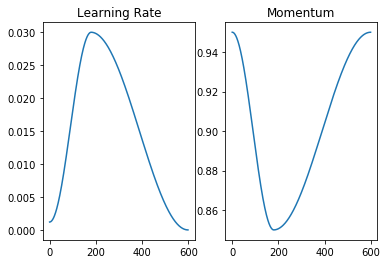

In [24]:
lr_schedule.plot()

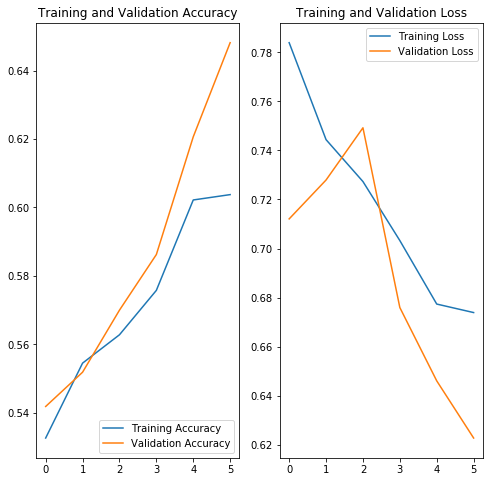

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()